# Tensorflow 2.0 GPU vs CPU Performance

In [2]:
import tensorflow as tf

print(tf.__version__)

tf.config.experimental.list_physical_devices(device_type=None)

2023-03-03 21:46:56.572009: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-03 21:46:56.681999: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-03 21:46:56.702639: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-03 21:46:57.150741: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

2.10.0


2023-03-03 21:46:57.521400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-03 21:46:57.544579: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-03 21:46:57.545034: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    
    print(e)

1 Physical GPUs, 1 Logical GPUs


2023-03-03 21:46:57.554784: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-03 21:46:57.555841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-03 21:46:57.555974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-03 21:46:57.556046: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so ret

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [8]:
import numpy as np                                
import matplotlib.pyplot as plt
import keras as k
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.models import load_model
from keras import backend as K
import time

In [9]:
#data preprocessing
(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows, img_cols = 28,28
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
x_test=x_test.astype('float32')
x_train=x_train.astype('float32')
mean=np.mean(x_train)
std=np.std(x_train)
x_test = (x_test-mean)/std
x_train = (x_train-mean)/std

print("counts of x_train : {}, y_train : {}, x_test : {}, y_test : {}".format(
    len(x_train), len(y_train), len(x_test), len(y_test)))

11490434/11490434 [==============================] - 1s 0us/step
counts of x_train : 60000, y_train : 60000, x_test : 10000, y_test : 10000


In [10]:
#labels
num_classes=10
y_train = k.utils.to_categorical(y_train, num_classes)
y_test = k.utils.to_categorical(y_test, num_classes)
print("counts of x_train : {}, y_train : {}, x_test : {}, y_test : {}".format(
    len(x_train), len(y_train), len(x_test), len(y_test)))

counts of x_train : 60000, y_train : 60000, x_test : 10000, y_test : 10000


### Tensorflow with CPU only

In [11]:
num_filter=32
num_dense=512
drop_dense=0.7
ac='relu'
learningrate=0.001

with tf.device("/cpu:0"):
    model = Sequential()

    model.add(Conv2D(num_filter, (3, 3), activation=ac, input_shape=(28, 28, 1),padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(num_filter, (3, 3), activation=ac,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 14x14x32

    model.add(Conv2D(2*num_filter, (3, 3), activation=ac,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(2*num_filter, (3, 3), activation=ac,padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 7x7x64 = 3136 neurons

    model.add(Flatten())                        
    model.add(Dense(num_dense, activation=ac))
    model.add(BatchNormalization())
    model.add(Dropout(drop_dense))
    model.add(Dense(10, activation='softmax'))

    adm=Adam(lr=learningrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=adm)


/home/shaik/tensorflow/tensorenv/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
cpu_list=[]
batch_sizes = []
with tf.device("/cpu:0"):
    for i in range(0,7):
        k=8*2**i
        print("batch size "+str(k))
        t1 = time.time()
        model.fit(x_train, y_train, batch_size=k, epochs=1, validation_data=(x_test, y_test))
        t2 = time.time()
        cpu_list.append(int(t2-t1))
        batch_sizes.append(k)

batch size 8
7500/7500 [==============================] - 64s 8ms/step - loss: 0.2238 - accuracy: 0.9337 - val_loss: 0.1147 - val_accuracy: 0.9733
batch size 16
3750/3750 [==============================] - 46s 12ms/step - loss: 0.0713 - accuracy: 0.9790 - val_loss: 0.0364 - val_accuracy: 0.9894
batch size 32
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0404 - accuracy: 0.9877 - val_loss: 0.0383 - val_accuracy: 0.9901
batch size 64
938/938 [==============================] - 29s 31ms/step - loss: 0.0236 - accuracy: 0.9932 - val_loss: 0.0178 - val_accuracy: 0.9946
batch size 128
469/469 [==============================] - 28s 60ms/step - loss: 0.0138 - accuracy: 0.9958 - val_loss: 0.0142 - val_accuracy: 0.9956
batch size 256
235/235 [==============================] - 27s 116ms/step - loss: 0.0095 - accuracy: 0.9969 - val_loss: 0.0138 - val_accuracy: 0.9961
batch size 512
118/118 [==============================] - 26s 221ms/step - loss: 0.0071 - accuracy: 0.9980 - va

In [13]:
print("cpu_list : ", cpu_list)

cpu_list :  [63, 46, 33, 29, 28, 27, 26]


### Tensorflow with GPU only

In [14]:
#build model

num_filter=32
num_dense=512
drop_dense=0.7
ac='relu'
learningrate=0.001

model = Sequential()

model.add(Conv2D(num_filter, (3, 3), activation=ac, input_shape=(28, 28, 1),padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filter, (3, 3), activation=ac,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 14x14x32

model.add(Conv2D(2*num_filter, (3, 3), activation=ac,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(2*num_filter, (3, 3), activation=ac,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 7x7x64 = 3136 neurons

model.add(Flatten())                        
model.add(Dense(num_dense, activation=ac))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(10, activation='softmax'))

adm=Adam(lr=learningrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=adm)

Now we train the model with gpu or cpu for different batch sizes. The larger the batch size, the more the parallelisation of matrix multiplications in the gpu speeds up the training compared to the cpu. The gpu load goes up to 95 percent for batch size 512, with 1.6GB used. Much larger batches require better graphics cards.

In [15]:
# # with GPU (the default in my setup)
# for i in range(1,2):
#     k=8*2**i
#     print("batch size "+str(k))
#     model.fit(x_train, y_train, batch_size=k, epochs=1, validation_data=(x_test, y_test))

In [16]:
gpu_list=[]
batch_sizes = []
print("gpu_list : ", gpu_list)
with tf.device("/gpu:0"):
    for i in range(0,7):
        k=8*2**i
        print("batch size "+str(k))
        t1 = time.time()
        model.fit(x_train, y_train, batch_size=k, epochs=1, validation_data=(x_test, y_test))
        t2 = time.time()
        gpu_list.append(int(t2-t1))
        batch_sizes.append(k)

gpu_list :  []
batch size 8


2023-03-03 21:52:24.690996: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204
2023-03-03 21:52:26.783279: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


7500/7500 [==============================] - 51s 6ms/step - loss: 0.2270 - accuracy: 0.9327 - val_loss: 0.0499 - val_accuracy: 0.9844
batch size 16
3750/3750 [==============================] - 26s 7ms/step - loss: 0.0761 - accuracy: 0.9783 - val_loss: 0.0333 - val_accuracy: 0.9900
batch size 32
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0396 - accuracy: 0.9886 - val_loss: 0.0192 - val_accuracy: 0.9939
batch size 64
938/938 [==============================] - 8s 8ms/step - loss: 0.0234 - accuracy: 0.9930 - val_loss: 0.0196 - val_accuracy: 0.9944
batch size 128
469/469 [==============================] - 6s 12ms/step - loss: 0.0151 - accuracy: 0.9954 - val_loss: 0.0165 - val_accuracy: 0.9945
batch size 256
235/235 [==============================] - 5s 19ms/step - loss: 0.0098 - accuracy: 0.9967 - val_loss: 0.0128 - val_accuracy: 0.9960
batch size 512
118/118 [==============================] - 5s 34ms/step - loss: 0.0075 - accuracy: 0.9978 - val_loss: 0.0127 - val_a

In [17]:
print("gpu_list : ", gpu_list)

gpu_list :  [50, 26, 13, 7, 5, 4, 4]


### Test 1 :-  GPU VS CPU 

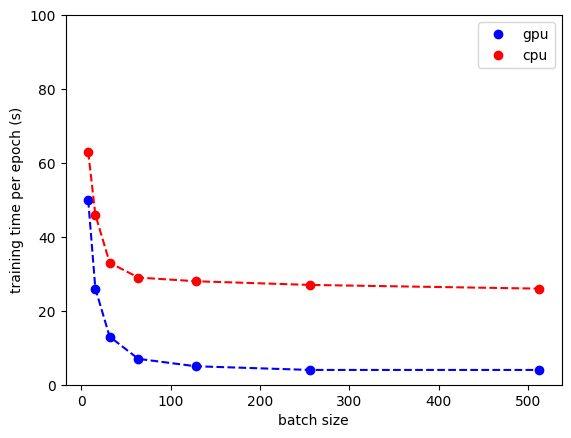

In [22]:
plt.plot(batch_sizes,gpu_list,'bo')
plt.plot(batch_sizes,cpu_list,'ro')
plt.plot(batch_sizes,gpu_list,'b--')
plt.plot(batch_sizes,cpu_list,'r--')
plt.ylabel('training time per epoch (s)')
plt.xlabel('batch size')
plt.legend(['gpu', 'cpu'], loc='upper right')
plt.ylim([0,100])
plt.show()

### Test 2 :-  GPU VS CPU 

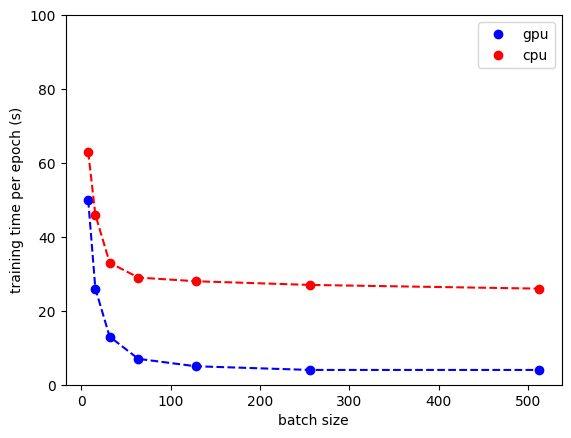

In [21]:
plt.plot(batch_sizes,gpu_list,'bo')
plt.plot(batch_sizes,cpu_list,'ro')
plt.plot(batch_sizes,gpu_list,'b--')
plt.plot(batch_sizes,cpu_list,'r--')
plt.ylabel('training time per epoch (s)')
plt.xlabel('batch size')
plt.legend(['gpu', 'cpu'], loc='upper right')
plt.ylim([0,100])
plt.show()

In [20]:
ratio_list=[j/k for (j, k) in zip(cpu_list,gpu_list)]
ratio_list

[1.26,
 1.7692307692307692,
 2.5384615384615383,
 4.142857142857143,
 5.6,
 6.75,
 6.5]